## Imports

In [2]:
import keras

Using TensorFlow backend.


In [2]:
import sys
import os
import numpy as np
import numpy.lib.recfunctions as nprf
from sklearn import linear_model
import matplotlib as mpl
from scipy.stats import gaussian_kde

mpl.rcParams['figure.figsize'] = (7,7)
mpl.rcParams['figure.facecolor'] = (1,1,1,1)
mpl.rcParams.update({'font.size':22})

% matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
from tools.matt_tools import *
from tools.cnn_tools import *

In [4]:
wdir = '/home/mho1/scratch/halo_cnn'

# Algorithm Design

## Data Load

In [8]:
dat_orig = np.load(wdir+"halo_cnn/data/MDPL2_large_z=0.117.npy")

In [9]:
keep = ['Mtot', 'rotation', 'fold', 'Ngal', 'vlos', 'Rproj',
        'name', 'intest', 'intrain', 'redshift','sigmav', 'xyproj'
       ]
print sys.getsizeof(dat_orig)/10.**9, ' GB'

temp = nprf.drop_fields(dat_orig, 
                            [i for i in dat_orig.dtype.names if i not in keep])

print sys.getsizeof(temp)/10.**9, ' GB'

del(dat_orig)

dat_orig = temp

7.046732052  GB
1.72686154  GB


## Data Preprocess

In [7]:
dat = dat_orig[(dat_orig['Mtot']>10**14) & (dat_orig['Mtot']<10**15) & (dat_orig['intrain']==1)]

# dat = np.random.choice(dat, 100, replace=False)

print dat.shape

(9921,)


In [10]:
# xmax, ymax = dat['xyproj'].max(axis=1).max(axis=0)
# vmax = dat['vlos'].max()


vmax = 5.33
xmax = 3.37
ymax = 3.31

print xmax, ymax, vmax

3.37 3.31 5.33


In [9]:
m = np.log10(dat['Mtot'])
m = m.reshape((len(m),1))

# Xarr = [np.ndarray(shape=(3,dat['Ngal'][i])) for i in range(len(dat))]
Xstd = np.ndarray(shape=(len(dat),3))
Xkde = np.ndarray(shape = (len(dat), 32, 32, 32))
Xmax = np.ndarray(shape=(len(dat),3))

mesh = np.mgrid[-vmax:vmax:32j, -xmax:xmax:32j, -ymax:ymax:32j]
positions = np.vstack([mesh[0].ravel(), mesh[1].ravel(), mesh[2].ravel()])

In [10]:
for i in range(len(dat)):
    if i%500==0: print i
    
    Xarr = np.ndarray(shape=(3,dat['Ngal'][i]))
    
    Xarr[0,:] = dat['vlos'][i][:dat['Ngal'][i]]
    Xarr[1:,:] = np.array(zip(*dat['xyproj'][i][:dat['Ngal'][i]]))
    
    Xarr = Xarr - Xarr.mean(axis=1).reshape((3,1)) # shift to 0 mean
    
    Xstd[i,:] = Xarr.std(axis=1)
    
    Xarr = Xarr/Xstd[i,:].reshape((3,1))
    
    Xmax[i,:] = Xarr.max(axis=1)
    
#     kde = gaussian_kde(Xarr)
#     kdeval = np.reshape(kde(positions).T, mesh[0].shape)
    kdeval = np.zeros(mesh[0].shape)
    
    Xkde[i,:,:,:] = kdeval

Xkde = Xkde.astype('float32')
Xkde /= Xkde.max()

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


nan

/home/mho1/miniconda2/lib/python2.7/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


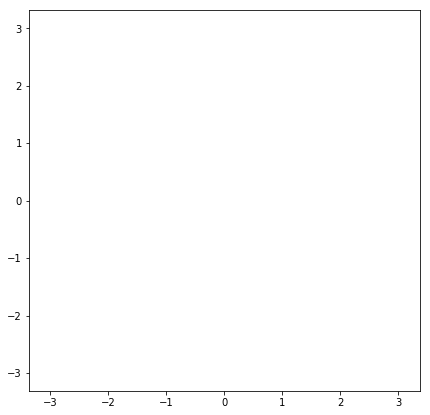

In [11]:
i = np.random.randint(len(dat))
v = 15

f3 = plt.figure(figsize=(7,7))

plt.imshow(np.rot90(Xkde[i][v], k=1), extent=[-xmax,xmax, -ymax , ymax], 
           aspect='auto',cmap=plt.cm.winter, vmax=1)

Xkde[i].max()

regr coef:  [[ 1.8835376  -0.10916214 -0.00657355]]
regr intercept:  [ 9.27462473]
regr R^2:  0.764971166024


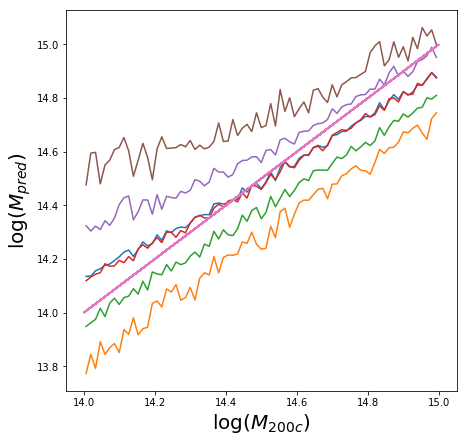

In [12]:
X = np.log10(Xstd)

regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(X,m)


print 'regr coef: ', regr.coef_
print 'regr intercept: ', regr.intercept_
print 'regr R^2: ', regr.score(X,m)

Mpred = regr.predict(X)

f = plt.figure(figsize=(7,7))

out = binnedplot(m,
                 Mpred, 
                 n=75,
                 percentiles = [2,15,50,85,98]
                )

plt.plot(m,m, label='fit')

plt.xlabel('$\log(M_{200c})$', fontsize=20)
plt.ylabel('$\log(M_{pred})$', fontsize=20)

# plt.legend()

# savefig(f,out_dat + '_massvsig_prebuffer', xlabel=r'$log(M_{200c})$', ylabel=r'$log(\sigma_v)$')

In [13]:
Y = m > Mpred
Y = Y.astype('int')
np.sum(Y)

5499

In [14]:

mdiff = (Mpred - m)
print mdiff.mean()
print mdiff.std()

mdiff = (mdiff - mdiff.mean())
mdiff_s = np.sort(mdiff, axis=0)

bins = 6
borders = [mdiff_s[i * len(mdiff_s)/bins] for i in range(0,bins)]

Mbins = np.ndarray(shape=(len(mdiff),1))

for i in range(len(mdiff)):
    
    Mbins[i] = bins-1
    
    for j in range(bins - 1):
        if ((borders[j] <= mdiff[i]) & (borders[j+1] > mdiff[i])):
            Mbins[i] = j
            break



4.19120662198e-15
0.138978559537


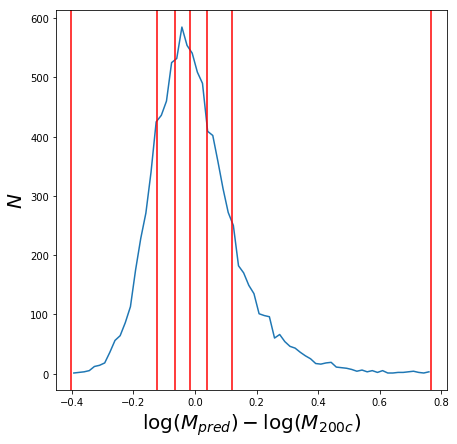

In [15]:
f, ax = plt.subplots(figsize=(7,7))

out = histplot(mdiff, n=70, log=False)

for i in borders + [mdiff_s[-1]]:
    ax.axvline(i, color='r')
    
plt.xlabel(r'$\log(M_{pred}) - \log(M_{200c})$', fontsize=20)
plt.ylabel('$N$', fontsize=20)

## Train and test

In [16]:
Xkde = np.reshape(Xkde, list(Xkde.shape) + [1])

indices = list(range(len(dat)))
test = np.random.choice(indices, int(len(dat)/10), replace=False)
train = [i for i in range(len(dat)) if i not in test]

x_train = Xkde[train,:,:,:]
y_train = Y[train]

x_test = Xkde[test,:,:,:]
y_test = Y[test]

## Model

In [17]:
batch_size = 10
num_classes = 2
epochs = 100

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv3D, MaxPooling3D

In [ ]:
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv3D(16, (3, 3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(16, (3, 3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('softmax'))

In [ ]:
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

print model.summary()

## Train

In [137]:
hist = model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  shuffle=True,
                  verbose=1)

Train on 90 samples, validate on 10 samples
Epoch 1/100
90/90 [==============================] - 11s 121ms/step - loss: 6.0227 - acc: 0.6222 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 2/100
90/90 [==============================] - 11s 121ms/step - loss: 6.0227 - acc: 0.6222 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 3/100
90/90 [==============================] - 11s 121ms/step - loss: 6.0227 - acc: 0.6222 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 4/100
90/90 [==============================] - 11s 121ms/step - loss: 6.0227 - acc: 0.6222 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 5/100
90/90 [==============================] - 11s 121ms/step - loss: 6.0227 - acc: 0.6222 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 6/100
90/90 [==============================] - 11s 121ms/step - loss: 6.0227 - acc: 0.6222 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 7/100
90/90 [==============================] - 11s 121ms/step - loss: 6.0227 - acc: 0.6222 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 8/100
90/90 

KeyboardInterrupt: 

## Results

In [ ]:
f = plt.figure(figsize=[8,6])
plt.plot(hist.history['loss'],'r',linewidth=3.0)
plt.plot(hist.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
# f.savefig(os.path.join(model_dir,'training_loss.pdf'))

f = plt.figure(figsize=[8,6])
plt.plot(hist.history['acc'],'r',linewidth=3.0)
plt.plot(hist.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
# f.savefig(os.path.join(model_dir,'training_acc.pdf'))

# Out data

In [5]:
# vmax = 5.33
# xmax = 3.37
# ymax = 3.31

# vmax=3.6
# rmax=1.53

vmax = 3409.98
rmax = 2.2999

## 2d

In [11]:
model_name = 'halo_cnn2d'

data_dir = os.path.join(wdir,'data',model_name)

In [12]:
X = np.load(os.path.join(data_dir, model_name + '_x.npy'))
Y = np.load(os.path.join(data_dir, model_name + '_y.npy'))

In [13]:
cmax = X.max()
print cmax

# X /= cmax
# cmax = X.max()
# print cmax

# X[X<0.1]=0

1.0


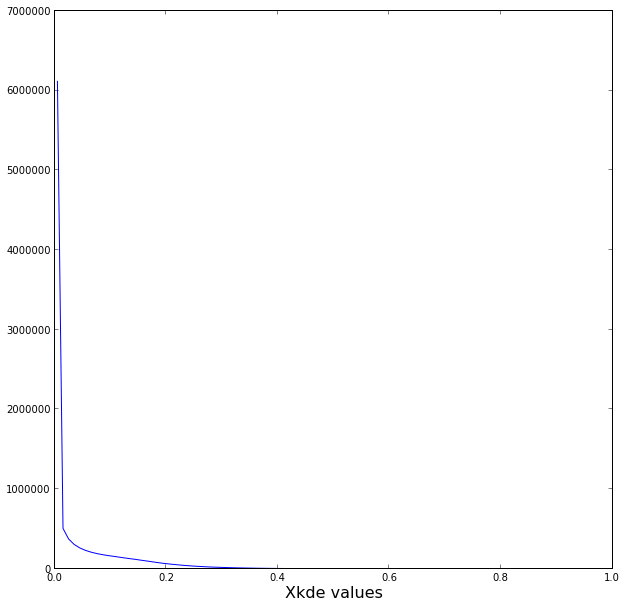

In [14]:
X = np.load(os.path.join(data_dir, model_name + '_x.npy'))

# X_sort = np.sort(X.flatten())
# for i in range(len(X)):
#     for j in range(len(X[i])):
#         for k in range(len(X[i][j])):
#             X[i,j,k] = np.random.choice(np.where(X_sort == X[i,j,k])[0])
# X[X==0] = X[X!=0].min()
# X = np.log10(X)
# X-=X.min()
# X/=X.max()
# X = X.astype('float32')
# X/= X.max()

m = histplot(X, n=100,log=False)
plt.xlabel('Xkde values', fontsize=16)

[ 2.]


/usr/lib64/python2.7/site-packages/matplotlib/collections.py:526: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


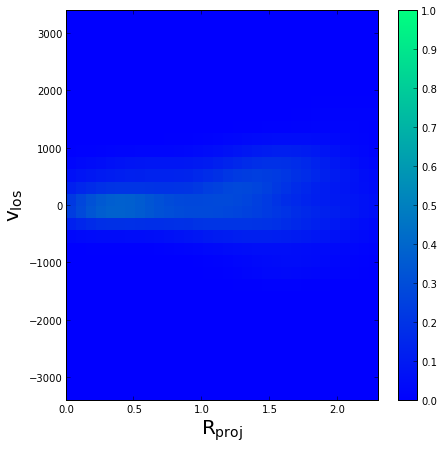

In [15]:
i = np.random.randint(len(X))

f3 = plt.figure(figsize=(7,7))

plt.imshow(np.rot90(X[i].T, k=3), extent=[0, rmax,-vmax,vmax], 
           aspect='auto',cmap=plt.cm.winter, interpolation='none', vmax=cmax)

plt.xlabel(r'$R_{proj}$', fontsize=20)
plt.ylabel(r'$v_{los}$', fontsize=20)
plt.colorbar()
print (Y[i])

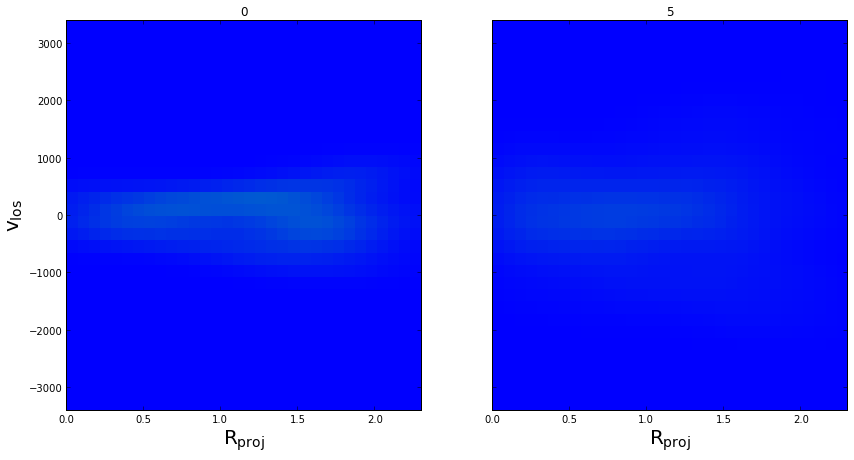

In [16]:
bin1, bin2 = (0, 5)

c1 = np.random.choice([i for i in range(len(Y)) if Y[i] == bin1])
c2 = np.random.choice([i for i in range(len(Y)) if Y[i] == bin2])

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,7))

ax1.imshow(np.rot90(X[c1].T, k=3), extent=[0, rmax,-vmax,vmax], 
           aspect='auto',cmap=plt.cm.winter, vmax=cmax, interpolation='none')
ax2.imshow(np.rot90(X[c2].T, k=3), extent=[0, rmax,-vmax,vmax], 
           aspect='auto',cmap=plt.cm.winter, vmax=cmax, interpolation='none')

ax1.set_title(str(bin1))
ax2.set_title(str(bin2))
ax1.set_xlabel(r'$R_{proj}$', fontsize=20)
ax2.set_xlabel(r'$R_{proj}$', fontsize=20)
ax1.set_ylabel(r'$v_{los}$', fontsize=20)

# f.savefig(wdir+'images/' + 'bin_unnorm.pdf')

In [17]:
np.sum(X[c2])

41.430733

## 1d

In [6]:
model_name = 'halo_cnn1d_r'

data_dir = os.path.join(wdir,'data',model_name)

In [7]:
dat = np.load(os.path.join(data_dir, model_name + '.npy'), encoding='latin1').item()
X = dat['X']
Y = dat['Y']
in_train = dat['in_train']

In [8]:
cmax = X.max()
print cmax

0.39738


[ 14.58686829]


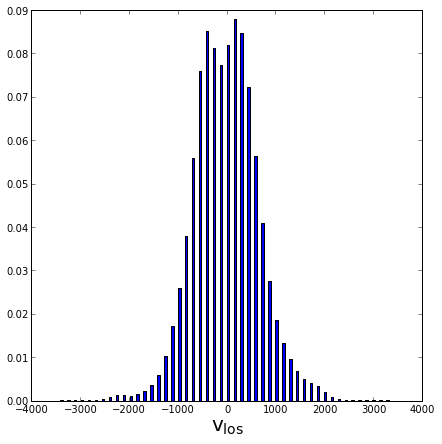

In [9]:
i = np.random.randint(len(X))

f3 = plt.figure(figsize=(7,7))

plt.bar(np.arange(-vmax, vmax, 2*vmax/len(X[i])),X[i], width=50)

plt.xlabel(r'$v_{los}$', fontsize=20)
print (Y[i])

### Model weights

In [10]:
model_num = 90

model_dir = os.path.join(wdir, 'saved_models',model_name)
model_path = os.path.join(model_dir, model_name+'_'+str(model_num), 
                          model_name+'_' + str(model_num) + '.h5')

from keras.models import load_model

model = load_model(model_path)

Using TensorFlow backend.


In [11]:
x = model.get_weights()

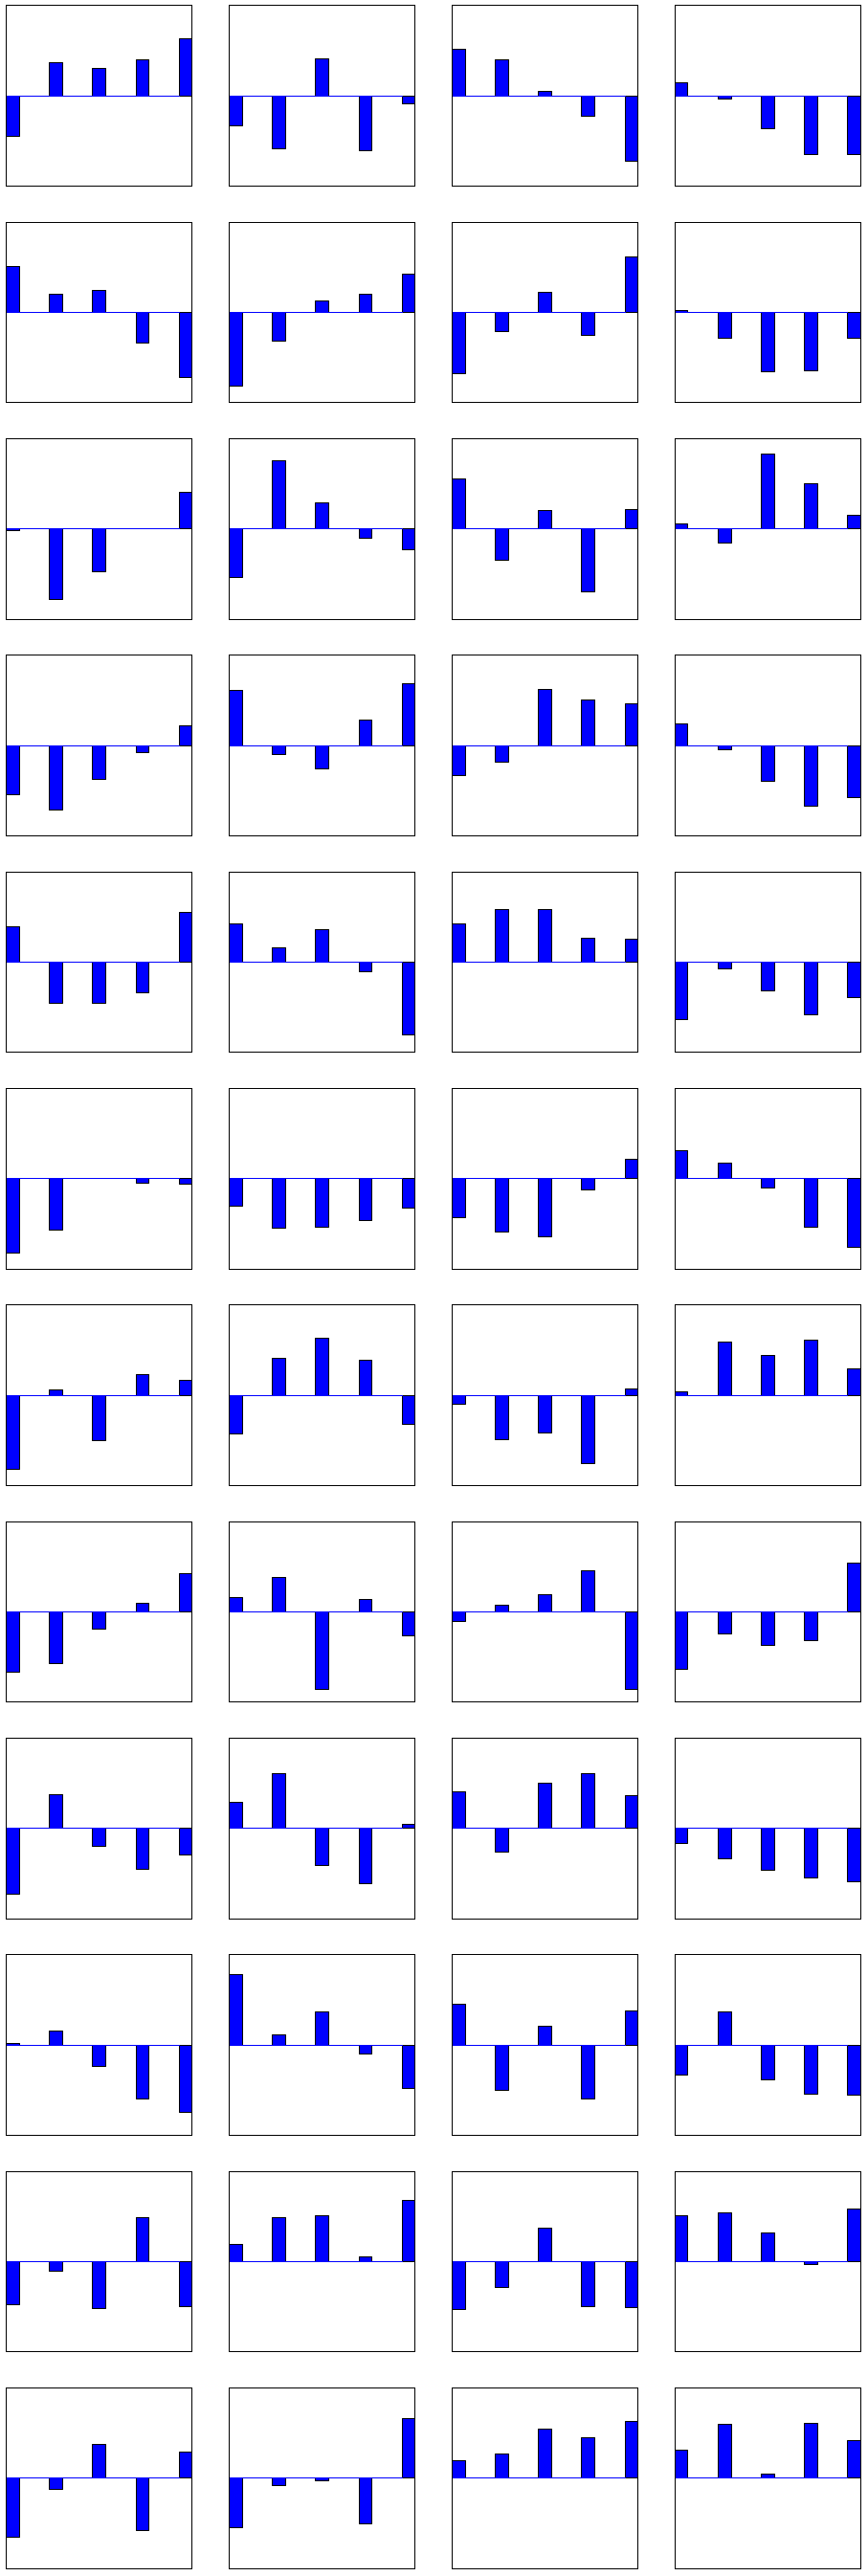

In [12]:
layer = 0
shape = list(x[layer].shape)

# shape[-1]=10

max_x = np.abs(x[layer]).max()

xrow = 4
yrow = int((shape[-1]+0.5)/xrow+0.5)

f = plt.figure(figsize=(xrow*4,yrow*4))
gs = mpl.gridspec.GridSpec(yrow,xrow)

axarr = [None] *shape[-1]    

for i in range(shape[-1]):
    filt = x[layer][:,:,i].flatten()
    filt /= np.linalg.norm(filt)
    
    if i == 0:
        axarr[0] = f.add_subplot(gs[0,0])
    else:
        axarr[i] = f.add_subplot(gs[i/xrow, i%xrow],
                                sharex=axarr[0], sharey=axarr[0]
                               )

    axarr[i].plot(np.arange(shape[0]),[0]*shape[0])
    axarr[i].bar(np.arange(shape[0]),filt, width=0.3)
    axarr[i].set_ylim(-1,1)
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])

(-1, 1)

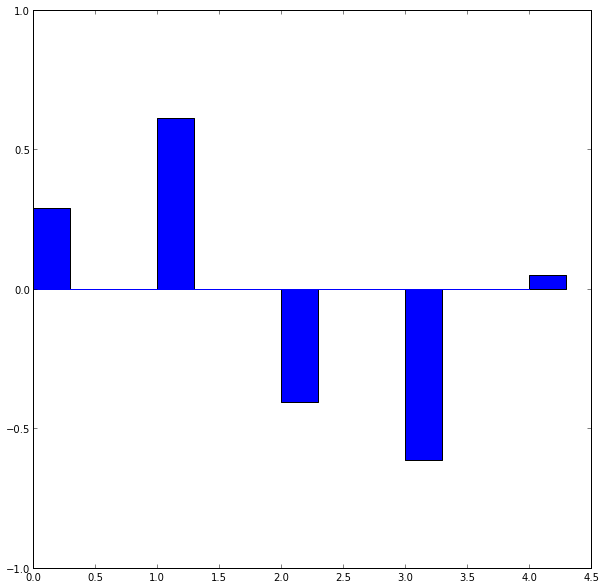

In [13]:
i = np.random.randint(shape[-1])

filt = x[layer][:,:,i].flatten()
filt /= np.linalg.norm(filt)

plt.figure()
plt.plot(np.arange(shape[0]),[0]*shape[0])
plt.bar(np.arange(shape[0]),filt, width=0.3)
plt.ylim(-1,1)

# Data

In [5]:
model_name = 'halo_cnn1d'

data_dir = os.path.join(wdir,'data',model_name)

In [6]:
d = np.load(os.path.join(data_dir, model_name + '.npy')).item()

In [12]:
print d.keys()

[u'Y', u'X', u'dat_params', u'm', u'in_train']


In [7]:
type(d['dat_params']['borders'][0])

numpy.float64

In [8]:
x = {'123':123}
x['temp'] = 'yo'
str(x)

"{'123': 123, 'temp': 'yo'}"

In [9]:
np.dot([[1,2,3],[4,5,6]],[1,2,3])

array([14, 32])

In [10]:
np.array([[1,2,3],[4,5,6]]).shape
np.array([1,2,3]).shape

(3,)

# Uni Machine

In [16]:
uni_dat_path = os.path.join(wdir,'data','sfr_catalog_0.671200.npy')
uni_dat = np.load(uni_dat_path)


In [25]:
uni_dat.dtype.names

('x',
 'y',
 'z',
 'vx',
 'vy',
 'vz',
 'upid',
 'id',
 'mvir',
 'mpeak',
 'obs_sm',
 'obs_sfr')

In [27]:
uni_dat[['id','upid']][:10]

array([(       9772896080,         -1), (43000002460545783, 9772896080),
       (26000005231481032, 9772896080), (40000002900107172, 9772896080),
       (28000004879831165, 9772896080), (31000004360511635, 9772896080),
       (23000005764327304, 9772896080), (22000005942826643, 9772896080),
       (51000001450535234, 9772896080), (12000007722938411, 9772896080)],
      dtype=[('id', '<i8'), ('upid', '<i8')])